In [49]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
import math
from IPython.display import Audio

In [50]:
def get_spectrogram(audio_arr):
    # Create BFT object and extract mel spectrogram
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=SAMPLE_RATE,
                     scale_type=SpectralFilterBankScaleType.MEL)

    spec_arr = bft_obj.bft(audio_arr)
    spec_arr = np.abs(spec_arr)
    return bft_obj, spec_arr

96818


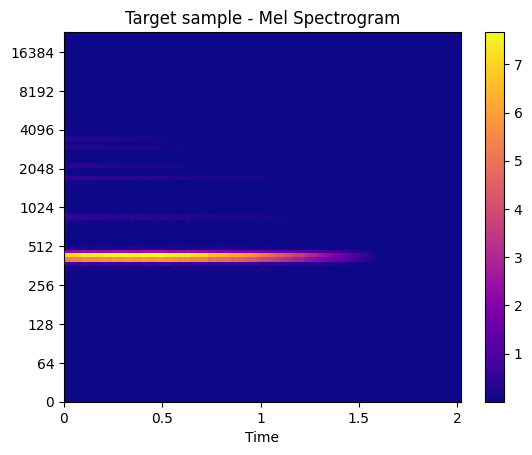

In [52]:
audio_arr, sr = af.read("/home/wint3rmute/Downloads/out.wav")
sample_arr = audio_arr
NUM_SAMPLES = sample_arr.shape[-1]
SAMPLE_RATE = 48000

bft_obj, spec_arr = get_spectrogram(audio_arr)
sample_spectrogram = spec_arr

# Display spectrogram

import matplotlib.pyplot as plt

from audioflux.display import fill_spec

audio_len = audio_arr.shape[-1]
print(audio_len)

fig, ax = plt.subplots()

img = fill_spec(spec_arr, axes=ax,

          x_coords=bft_obj.x_coords(audio_len),

          y_coords=bft_obj.y_coords(),

          x_axis='time', y_axis='log',

          title='Target sample - Mel Spectrogram')

fig.colorbar(img, ax=ax)
Audio(data=sample_arr, rate=SAMPLE_RATE)

96818


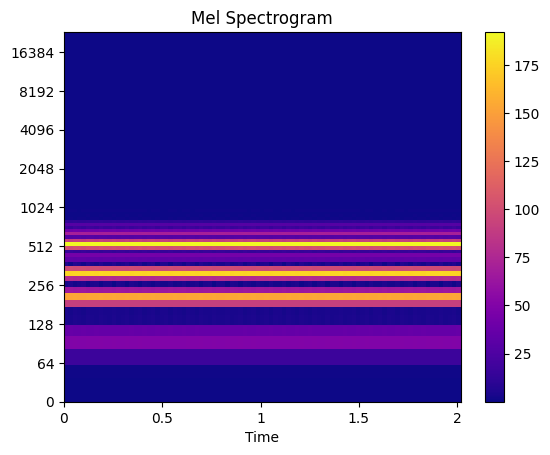

In [4]:
class SineSource:
    def __init__(self, frequency: float):
        self.frequency = frequency
        self.phase = 0.0
        self.phase_diff = (2.0 * math.pi * frequency) / SAMPLE_RATE
    
    def tick(self, modulation):
        result = math.sin(self.phase + modulation)
        self.phase += self.phase_diff
        return result

def play_synth(mod_mult, mod_strength):
    source = SineSource(440)
    modulator = SineSource(440 * mod_mult)

    audio_arr = np.zeros(NUM_SAMPLES)
    sr = SAMPLE_RATE

    for i in range(NUM_SAMPLES):
        # print("tick")
        audio_arr[i] = source.tick(modulator.tick(0) * mod_strength)
        # modulator.phase_diff += 0.00000001
    return audio_arr

audio_arr = play_synth(0.25, 2)


bft_obj, spec_arr = get_spectrogram(audio_arr)

audio_len = audio_arr.shape[-1]
print(audio_len)

fig, ax = plt.subplots()
img = fill_spec(spec_arr, axes=ax,
          x_coords=bft_obj.x_coords(audio_len),
          y_coords=bft_obj.y_coords(),
          x_axis='time', y_axis='log',
          title='Mel Spectrogram')

fig.colorbar(img, ax=ax)
# plt.show()
# print(spec_arr)

In [38]:
from scipy.optimize import differential_evolution

def target_fun(arg):
    audio_arr = play_synth(arg[0], arg[1])
    bft_obj, synth_spectrogram = get_spectrogram(audio_arr)

    return abs(sum(sum(synth_spectrogram - sample_spectrogram)))
# synth_spectrogram.shape

def callback(xk, convergence):
    print(xk)

result = differential_evolution(target_fun, bounds=[ (-1, 2), (-1, 2)], callback=callback, popsize=20, maxiter=30, workers=8)
result

[1.99315021 1.89159953]
[1.99315021 1.89159953]
[1.99315021 1.89159953]
[1.92986891 1.94888155]
[1.92986891 1.94888155]
[1.92986891 1.94888155]
[1.92986891 1.94888155]
[1.92986891 1.94888155]
[1.98551179 1.84594443]
[1.98551179 1.84594443]
[1.93398686 1.83855063]
[1.93398686 1.83855063]
[1.93398686 1.83855063]
[1.93398686 1.83855063]
[1.93398686 1.83855063]
[1.93398686 1.83855063]
[1.93398686 1.83855063]
[1.93398686 1.83855063]
[1.93622989 1.99491992]
[1.93622989 1.99491992]
[1.93622989 1.99491992]
[1.93452951 1.97554977]
[1.93452951 1.97554977]
[1.93452951 1.97554977]
[1.93452951 1.97554977]
[1.93461235 1.97976424]
[1.93461235 1.97976424]
[1.93493013 1.98607695]
[1.93554382 1.98806506]
[1.9356927  1.99869782]


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 14839.700698852539
       x: [ 1.935e+00  1.998e+00]
     nit: 30
    nfev: 1330
     jac: [ 3.586e+04  3.586e+04]

96818


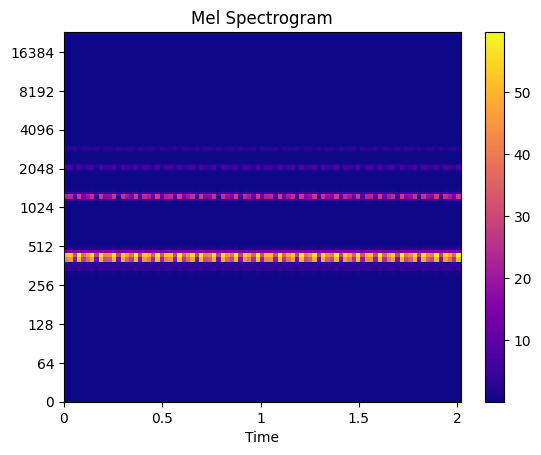

In [58]:
audio_arr = play_synth(result.x[0], result.x[1])

bft_obj, spec_arr = get_spectrogram(audio_arr)

audio_len = audio_arr.shape[-1]
print(audio_len)

fig, ax = plt.subplots()
img = fill_spec(spec_arr, axes=ax,
          x_coords=bft_obj.x_coords(audio_len),
          y_coords=bft_obj.y_coords(),
          x_axis='time', y_axis='log',
          title='Mel Spectrogram')

fig.colorbar(img, ax=ax)

In [47]:
# bft_obj, target_arr = get_spectrogram(play_synth(0.25, 2))
# bft_obj, spec_arr_2 = get_spectrogram(play_synth(0.25, 2))

# abs(sum(sum(target_arr - spec_arr_2)))
r = af.write("/tmp/test.wav", audio_arr, SAMPLE_RATE)
# print(r)

Audio(data=audio_arr, rate=SAMPLE_RATE)